<a href="https://colab.research.google.com/github/HadeerArafa/VGG_Subclassing/blob/main/VGG_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

you will build a class that implements a [VGG network](https://towardsdatascience.com/vgg-neural-networks-the-next-step-after-alexnet-3f91fa9ffe2c) that can be trained to classify images. The model will look something like this:



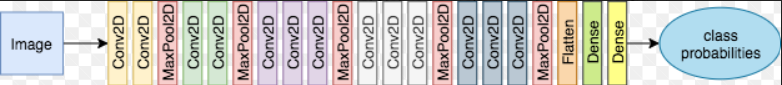

It is primarily made up of a series of Conv2D layers followed by a softmax activated layers to classify the image. As you can see, this will be a handful and the code will look huge if you specify each layer individually. As shown in the lectures, you can instead use model subclassing to build complex architectures. You can encapsulate repeating parts of a network then reuse that code when building the final model. You will get to practice that in this exercise. Let's get started!

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

## Create a generic VGG block 

The VGG Network has blocks of layers, where each block has a varied number of layers.
- In order to create blocks of layers that have a customizable number of conv2D layers, you'll define a class `Block`, which can generate a customizable block of layers 


### `__init__`
In the constructor `__init__`, store the conv2D parameters and also define the number of conv2D layers using the parameters passed into `__init__`.
- Store the filters, kernel_size, and repetitions as class variables so that they can be used later in the `call` function.
- Using a for loop, define a number of Conv2D [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/) layers, based on the number of `repetitions` desired for this block.
    - You can define each conv2D layer using `vars` and string formatting to create conv2D_0, conv2D_1, conv2D_3 etc.
    - Set these four parameters of Conv2D:
        - filters
        - kernel_size
        - activation: set this to 'relu'
        - padding: set this to 'same' (default pading is 'valid').
        
- Define the [MaxPool2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/) layer that follows these Conv2D layers. 
    - Set the following parameters for MaxPool2D:
        - pool_size: this will be a tuple with two values.
        - strides: this will also be a tuple with two values.

### `call`
In `call`, you will connect the layers together.
- The 0-th conv2D layer, `conv2D_0`, immediately follows the `inputs`.
- For conv2D layers 1,2 and onward, you can use a for loop to connect conv2D_1 to conv2D_0, and connect conv2D_2 to conv2D_1, and so on.
- After connecting all of the conv2D_i layers, add connect the max_pool layer and return the max_pool layer.

In [ ]:

# each blocl in vgg consist of number of Con2D layers followed by MaxBooling layer
class Block(tf.keras.Model):
    def __init__(self, filters, kernel_size, repetitions, pool_size=2 , strides=2):
        super(Block, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.repetitions = repetitions
        self.pool_size = pool_size
        self.strides = strides
        # Define a conv2D_0, conv2D_1, etc based on the number of repetitions
        for i in range(repetitions):
            
            # Define a Conv2D layer, specifying filters, kernel_size, activation and padding.
            vars(self)[f'conv2D_{i}'] = tf.keras.layers.Conv2D( filters = self.filters ,
                                                                kernel_size = self.kernel_size,
                                                                activation='relu' , 
                                                                padding='same' )
        
        # Define the max pool layer that will be added after the Conv2D blocks
        self.max_pool = tf.keras.layers.MaxPool2D(pool_size = self.pool_size,
                                                   strides = self.strides )
  
    def call(self, inputs):
        # access the class's conv2D_0 layer
        conv2D_0 =  vars(self)[f'conv2D_0']
        
        # Connect the conv2D_0 layer to inputs
        x =  conv2D_0(inputs)

        # for the remaining conv2D_i layers from 1 to `repetitions` they will be connected to the previous layer
        for i in range(1, self.repetitions):
            # access conv2D_i by formatting the integer `i`. (hint: check how these were saved using `vars()` earlier)
            conv2D_i = vars(self)[f'conv2D_{i}']
            
            # Use the conv2D_i and connect it to the previous layer
            x = conv2D_i(x)

        # Finally, add the max_pool layer
        max_pool = self.max_pool(x)
        
        return max_pool

## Create the Custom VGG network 
This model stack has a series of VGG blocks, which can be created using the `Block` class that you defined earlier.

### `__init__`
- Recall that the `__init__` constructor of `Block` takes several function parameters, 
    - filters, kernel_size, repetitions: you'll set these.
    - kernel_size and strides: you can use the default values.
- For blocks a through e, build the blocks according to the following specifications:
- block_a: 64  filters, kernel_size 3, repetitions 2
- block_b: 128 filters, kernel_size 3, repetitions 2
- block_c: 256 filters, kernel_size 3, repetitions 3
- block_d: 512 filters, kernel_size 3, repetitions 3
- block_e: 512 filters, kernel_size 3, repetitions 3

After block 'e', add the following layers:
- flatten: use [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/).
- fc: create a fully connected layer using [Dense](https://keras.io/api/layers/core_layers/dense/).  Give this 256 units, and a `'relu'` activation.
- classifier: create the classifier using a Dense layer.  The number of units equals the number of classes.  For multi-class classification, use a `'softmax'` activation.

### `call`
Connect these layers together using the functional API syntax:
- inputs
- block_a
- block_b
- block_c
- block_d
- block_e
- flatten
- fc
- classifier

Return the classifier layer.

In [ ]:

class VGG(tf.keras.Model):

    def __init__(self, num_classes):
        super(VGG, self).__init__()

        # Creating blocks of VGG with the following 
        # (filters, kernel_size, repetitions) configurations
        self.block_a = Block(filters = 64,  kernel_size = 3, repetitions = 2)
        self.block_b = Block(filters = 128, kernel_size = 3, repetitions = 2)
        self.block_c = Block(filters = 256, kernel_size = 3, repetitions = 3)
        self.block_d = Block(filters = 512, kernel_size = 3, repetitions = 3)
        self.block_e = Block(filters = 512, kernel_size = 3, repetitions = 3)

        # Classification head
        # Define a Flatten layer
        self.flatten = tf.keras.layers.Flatten()
        # Create a Dense layer with 256 units and ReLU as the activation function
        self.fc = tf.keras.layers.Dense(units = 256 , activation = 'relu' )
        # Finally add the softmax classifier using a Dense layer
        self.classifier = tf.keras.layers.Dense(num_classes, activation = 'softmax')

    def call(self, inputs):
        # Chain all the layers one after the other
        x = self.block_a(inputs)
        x = self.block_b(x)
        x = self.block_c(x)
        x = self.block_d(x)
        x = self.block_e(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.classifier(x)
        return x

In [22]:

# Download the dataset
dataset = tfds.load('cats_vs_dogs', split='train', data_dir='data/') 

In [ ]:
# Initialize VGG with the number of classes 
vgg = VGG(num_classes=2)

# Compile with losses and metrics
vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [ ]:
def preprocess(features):
    # Resize and normalize
    image = tf.image.resize(features['image'], (224, 224))
    return tf.cast(image, tf.float32) / 255., features['label']

# Apply transformations to dataset
datatrain = dataset.map(preprocess).batch(32)

# Train the custom VGG model

In [ ]:
datatrain

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [9]:
vgg.fit(datatrain,epochs=20)

Epoch 1/20
727/727 [==============================] - 244s 304ms/step - loss: 0.6854 - accuracy: 0.5527
Epoch 2/20
727/727 [==============================] - 208s 286ms/step - loss: 0.6476 - accuracy: 0.6355
Epoch 3/20
727/727 [==============================] - 208s 286ms/step - loss: 0.6115 - accuracy: 0.6699
Epoch 4/20
727/727 [==============================] - 208s 286ms/step - loss: 0.5917 - accuracy: 0.6858
Epoch 5/20
727/727 [==============================] - 208s 286ms/step - loss: 0.5802 - accuracy: 0.6959
Epoch 6/20
727/727 [==============================] - 208s 286ms/step - loss: 0.5718 - accuracy: 0.7025
Epoch 7/20
727/727 [==============================] - 208s 286ms/step - loss: 0.5647 - accuracy: 0.7089
Epoch 8/20
727/727 [==============================] - 208s 286ms/step - loss: 0.5582 - accuracy: 0.7140
Epoch 9/20
727/727 [==============================] - 208s 286ms/step - loss: 0.5521 - accuracy: 0.7190
Epoch 10/20
727/727 [==============================] - 208s 286m

In [10]:
vgg.summary()

Model: "vgg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block (Block)               multiple                  0         
                                                                 
 block_1 (Block)             multiple                  0         
                                                                 
 block_2 (Block)             multiple                  0         
                                                                 
 block_3 (Block)             multiple                  0         
                                                                 
 block_4 (Block)             multiple                  0         
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  6422784 

In [32]:
vgg.weights

[<tf.Variable 'vgg/dense/kernel:0' shape=(25088, 256) dtype=float32, numpy=
 array([[-0.00395448, -0.01839892, -0.00744774, ..., -0.01524853,
         -0.00454255, -0.00553806],
        [ 0.00184624,  0.00976691, -0.00499901, ...,  0.0067742 ,
          0.01019505, -0.00152892],
        [-0.0107799 , -0.01126942, -0.01735481, ...,  0.00265579,
          0.00013795,  0.0071411 ],
        ...,
        [-0.01599722, -0.00021502, -0.01334078, ...,  0.01589712,
         -0.00512424,  0.00313727],
        [-0.01557594, -0.01462152,  0.0136279 , ..., -0.01005044,
         -0.00235562, -0.00599315],
        [ 0.00091149,  0.0045459 , -0.00584794, ..., -0.00825343,
         -0.01408683,  0.00853565]], dtype=float32)>,
 <tf.Variable 'vgg/dense/bias:0' shape=(256,) dtype=float32, numpy=
 array([-0.00790964, -0.00600361, -0.00446121,  0.02386906,  0.        ,
        -0.00600396, -0.00623603, -0.00569224, -0.00787743, -0.00108101,
        -0.0020276 , -0.00600425, -0.00674235,  0.        , -0.0060

In [35]:
vgg.save_weights('vgg_weights') # it will save the model in the colab and i can download it from there

> how to use the model again :
model_new = get_model()  
model_new.compile(optimizer=optimizer, loss=loss, metrics=metrics)    
model_new.load_weights(‘file_path.h5’)  
model_new.evaluate(x_test, y_test, **kwargs)

In [18]:
vgg_ = VGG(2)

In [29]:
vgg_.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [37]:
vgg_.load_weights('vgg_weights') 

In [38]:
vgg_.weights

[<tf.Variable 'vgg_1/dense_2/kernel:0' shape=(25088, 256) dtype=float32, numpy=
 array([[-0.00395448, -0.01839892, -0.00744774, ..., -0.01524853,
         -0.00454255, -0.00553806],
        [ 0.00184624,  0.00976691, -0.00499901, ...,  0.0067742 ,
          0.01019505, -0.00152892],
        [-0.0107799 , -0.01126942, -0.01735481, ...,  0.00265579,
          0.00013795,  0.0071411 ],
        ...,
        [-0.01599722, -0.00021502, -0.01334078, ...,  0.01589712,
         -0.00512424,  0.00313727],
        [-0.01557594, -0.01462152,  0.0136279 , ..., -0.01005044,
         -0.00235562, -0.00599315],
        [ 0.00091149,  0.0045459 , -0.00584794, ..., -0.00825343,
         -0.01408683,  0.00853565]], dtype=float32)>,
 <tf.Variable 'vgg_1/dense_2/bias:0' shape=(256,) dtype=float32, numpy=
 array([-0.00790964, -0.00600361, -0.00446121,  0.02386906,  0.        ,
        -0.00600396, -0.00623603, -0.00569224, -0.00787743, -0.00108101,
        -0.0020276 , -0.00600425, -0.00674235,  0.        ,